In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt 
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader

In [27]:
from datamodels.grassy_mnist import get_grassy_mnist
from models.cvae import ContrastiveVAE
from models.vae import VAE
from models.train import train
from datamodels.utils import plot_sweeps_mnist, plot_latent_space

In [28]:
target, target_labels, background = get_grassy_mnist(scale=2)

In [29]:
# model = ContrastiveVAE(input_dim=28*28, hidden_dim=32, latent_dim=2, regularizer="TC")
# model = ContrastiveVAE(input_dim=28*28, hidden_dim=32, latent_dim=2, regularizer="HSIC")
# model = ContrastiveVAE(input_dim=28*28, hidden_dim=32, latent_dim=2, regularizer=None)
# model = ContrastiveVAE(input_dim=28*28, hidden_dim=32, latent_dim=2, regularizer="MMD")
model = ContrastiveVAE(input_dim=28*28, hidden_dim=32, latent_dim=2, regularizer="Wasserstein")

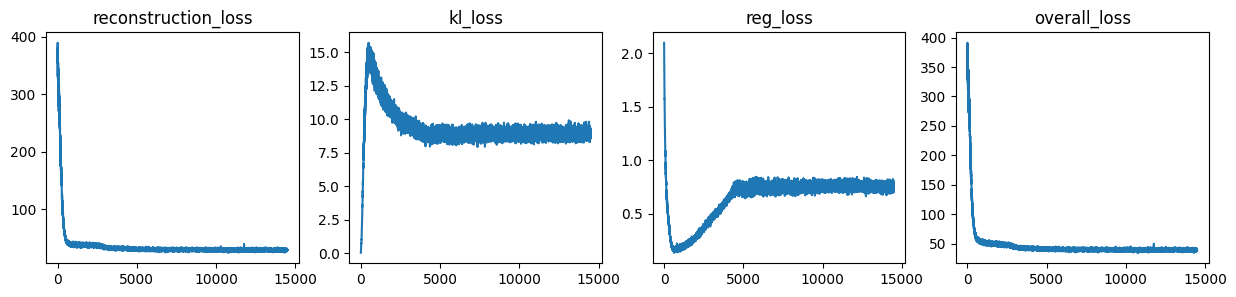

In [32]:
ds = torch.stack([target, background], axis=1)
dataloader = DataLoader(dataset=ds, batch_size=128, shuffle=True, drop_last=True)
optimizer = Adam(model.parameters(), lr=1e-4)
losses = train(model, dataloader, optimizer, epochs=100)

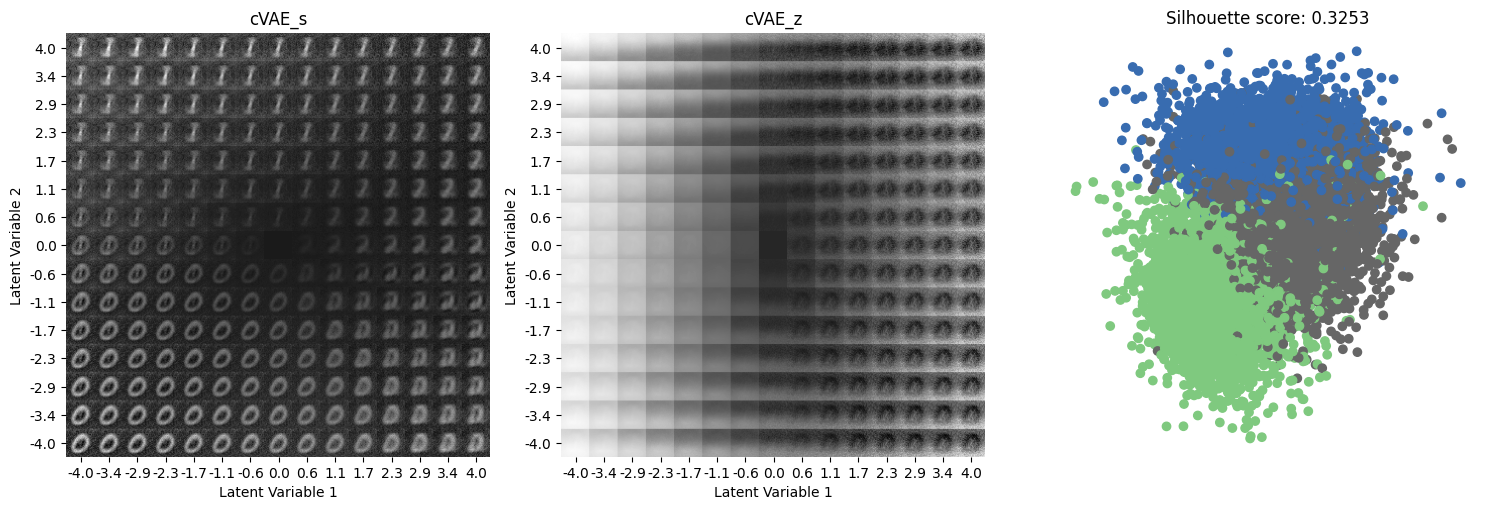

In [33]:
_, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15,5))
plot_sweeps_mnist(model.decoder, option="cVAE_s", ax=ax1)
plot_sweeps_mnist(model.decoder, option="cVAE_z", ax=ax2)
plot_latent_space(model.s_encoder, target, target_labels, ax=ax3)
plt.tight_layout();

In [21]:
from datamodels.utils import s_score

In [ ]:
scales = [1, 2, 3]
regularizers = [None, "TC", "HSIC", "MMD", "Wasserstein"]
ss_reg = {}

for scale in scales:
    target, target_labels, background = get_grassy_mnist(scale=scale)
    ds = torch.stack([target, background], axis=1)
    dataloader = DataLoader(dataset=ds, batch_size=128, shuffle=True, drop_last=True)
    ss_reg[scale] = {}
    for regularizer in regularizers:
        sss = []
        for trial in range(10):
            model = ContrastiveVAE(input_dim=28*28, hidden_dim=32, latent_dim=2, regularizer=regularizer)
            optimizer = Adam(model.parameters(), lr=1e-4)
            losses = train(model, dataloader, optimizer, epochs=100, plot=False)
            ss, _ = s_score(model.s_encoder, target, target_labels)
    
            print(f"regularizer={regularizer}; scale={scale}; trial={trial}; ss={ss:.4f}")
            sss.append(ss)
    
        ss_reg[scale][regularizer] = sss

regularizer=None; scale=1; trial=0; ss=0.3886
regularizer=None; scale=1; trial=1; ss=0.3702
regularizer=None; scale=1; trial=2; ss=0.3725
regularizer=None; scale=1; trial=3; ss=0.3872
regularizer=None; scale=1; trial=4; ss=0.3744
regularizer=None; scale=1; trial=5; ss=0.3874
regularizer=None; scale=1; trial=6; ss=0.3720
regularizer=None; scale=1; trial=7; ss=0.3915
regularizer=None; scale=1; trial=8; ss=0.3896
regularizer=None; scale=1; trial=9; ss=0.3940
regularizer=TC; scale=1; trial=0; ss=0.3759
regularizer=TC; scale=1; trial=1; ss=0.3895
regularizer=TC; scale=1; trial=2; ss=0.3758
regularizer=TC; scale=1; trial=3; ss=0.3942
regularizer=TC; scale=1; trial=4; ss=0.3898
regularizer=TC; scale=1; trial=5; ss=0.3754
regularizer=TC; scale=1; trial=6; ss=0.3670
regularizer=TC; scale=1; trial=7; ss=0.3923
regularizer=TC; scale=1; trial=8; ss=0.3771
regularizer=TC; scale=1; trial=9; ss=0.3687
regularizer=HSIC; scale=1; trial=0; ss=0.3913
regularizer=HSIC; scale=1; trial=1; ss=0.3872
regulari

In [ ]:
import pandas as pd 
pd.DataFrame(ss_reg).plot.box()

In [ ]:
# varying penalty?

In [40]:
# HSIC

In [42]:
out = _generic_inference(model, next(iter(dataloader)))

In [57]:
out["qz_m"].view(-1,2).shape

torch.Size([256, 2])

In [47]:
tg_qz_m, bg_qz_m = torch.chunk(out["qz_m"], chunks=2, dim=1)
tg_qs_m, bg_qs_m = torch.chunk(out["qs_m"], chunks=2, dim=1)

In [78]:
def rbf_kernel(X, sigma=1.0):
    distance = torch.cdist(X, X, p=2) ** 2
    return torch.div(-distance, (2*sigma**2)).exp()
    
def compute_HSIC(qz_m, qs_m):
    n = qz_m.shape[0]
    K = rbf_kernel(qz_m)
    L = rbf_kernel(qs_m)
    print(K.shape)
    H = torch.eye(n) - 1/n * torch.ones((n,n))
    # HSIC = 1/(n-1)**2 * torch.trace(K@H@L@H)
    HSIC = 1/n**2 * torch.trace(K@H@L@H)

    t1 = (1 / (n**2)) * torch.sum(K * L)
    t2 = (1 / (n**4)) * torch.sum(K) * torch.sum(L)
    t3 = (2 / (n**3)) * torch.sum(K@L)
    HSIC_2 = t1 + t2 - t3
    
    return HSIC, HSIC_2

In [79]:
compute_HSIC(out["qz_m"].view(-1, 2), 
             out["qs_m"].view(-1, 2))

torch.Size([256, 256])


(tensor(6.2544e-06, grad_fn=<MulBackward0>),
 tensor(6.3181e-06, grad_fn=<SubBackward0>))

In [82]:
torch.mean(rbf_kernel(out["qz_m"]))

tensor(0.9983, grad_fn=<MeanBackward0>)

In [12]:
from torch.distributions import Normal

def _generic_inference(model, x):
    _, qz_m, qz_lv = model.z_encoder(x)
    _, qs_m, qs_lv = model.s_encoder(x)

    # sample from latent distribution
    qz_lv = torch.maximum(qz_lv, torch.tensor(-20))
    qs_lv = torch.maximum(qs_lv, torch.tensor(-20))

    qz_s = torch.exp(qz_lv/2)
    qs_s = torch.exp(qs_lv/2)
    
    qz = Normal(qz_m, qz_s)
    qs = Normal(qs_m, qs_s)

    z = qz.rsample()
    s = qs.rsample()

    out = dict(qz_m=qz_m, qz_s=qz_s, z=z, qs_m=qs_m, qs_s=qs_s, s=s)
    return out

In [14]:
out = _generic_inference(model, next(iter(dataloader)))

In [17]:
out["qs_m"].shape

torch.Size([128, 2, 2])

In [24]:
background_tensor, target_tensor = torch.chunk(out["qs_m"], chunks=2, dim=1)

In [25]:
background_tensor.shape, target_tensor.shape

(torch.Size([128, 1, 2]), torch.Size([128, 1, 2]))

In [35]:
torch.norm(out["qs_m"], dim=(-1,-2)).pow(2)

tensor([2.9453, 0.8947, 0.9155, 0.7217, 0.5727, 1.0021, 0.6447, 0.5315, 0.2900,
        0.7308, 0.6214, 0.0945, 3.7300, 3.4551, 0.1733, 1.3530, 1.7135, 1.3299,
        0.7830, 0.3263, 0.6840, 1.1442, 0.6922, 1.2266, 0.2962, 0.6754, 0.1981,
        5.3532, 4.2146, 4.1236, 1.7613, 2.2805, 0.9128, 0.0734, 1.9002, 0.9827,
        0.1088, 0.6042, 0.5677, 0.1243, 0.5026, 0.4713, 0.4562, 0.2573, 0.6570,
        2.5591, 0.6338, 0.5293, 1.6674, 1.7416, 0.6142, 1.6921, 1.0038, 0.5773,
        0.3105, 0.7103, 1.3685, 0.4582, 1.5978, 3.8697, 0.9788, 1.0716, 0.3764,
        0.1109, 0.8635, 1.8149, 1.6939, 0.3136, 3.4276, 1.7236, 0.8562, 0.8285,
        2.3017, 0.5608, 0.2453, 2.0626, 1.5424, 0.0200, 0.8895, 2.4484, 0.4658,
        1.5893, 0.8612, 0.6105, 1.1692, 0.6603, 1.3980, 0.7589, 3.8867, 0.1151,
        0.4792, 1.0176, 2.1491, 0.6576, 0.5094, 0.9620, 0.4768, 0.0133, 0.4048,
        0.6551, 0.1820, 1.5320, 1.1421, 0.6803, 0.4293, 2.1250, 2.4869, 0.2550,
        1.7650, 0.5585, 0.8840, 0.4500, 

In [37]:
torch.norm(out["qs_s"], dim=(-1,-2)).pow(2)

tensor([1.4387, 2.3464, 0.8497, 1.6084, 1.6380, 1.9925, 1.7860, 1.6006, 1.5027,
        2.1213, 1.0213, 2.0289, 0.9355, 1.3772, 1.1493, 1.6918, 1.9920, 1.6686,
        2.1603, 1.5064, 2.5473, 1.5116, 1.4129, 1.6954, 1.8544, 1.4831, 2.1419,
        1.8724, 1.1625, 1.7994, 1.9180, 1.0985, 1.8524, 1.5395, 2.2365, 1.4364,
        1.5700, 1.6171, 1.5850, 1.4751, 2.0736, 1.7821, 2.2062, 1.5979, 1.9595,
        1.8025, 1.4088, 1.2815, 1.2900, 1.6271, 1.7701, 1.9971, 1.5375, 1.8070,
        1.7678, 1.8442, 0.9706, 1.7908, 2.6370, 1.4363, 1.9337, 1.2905, 1.6123,
        0.8317, 1.9048, 1.7999, 1.6977, 1.7524, 1.4198, 1.7343, 2.8339, 1.4987,
        1.9513, 1.6604, 1.7085, 2.0529, 1.0292, 1.8286, 1.2141, 1.1793, 2.2033,
        1.6063, 2.3729, 1.4237, 1.7172, 1.9832, 1.8245, 1.9243, 1.1411, 1.2016,
        2.0507, 1.2017, 1.3613, 1.6000, 1.1540, 1.3102, 1.4029, 2.0465, 1.6193,
        1.0896, 1.8390, 2.4668, 2.1365, 1.9245, 1.7870, 1.0677, 1.5829, 1.6263,
        1.6807, 1.6971, 1.2646, 1.3507, 

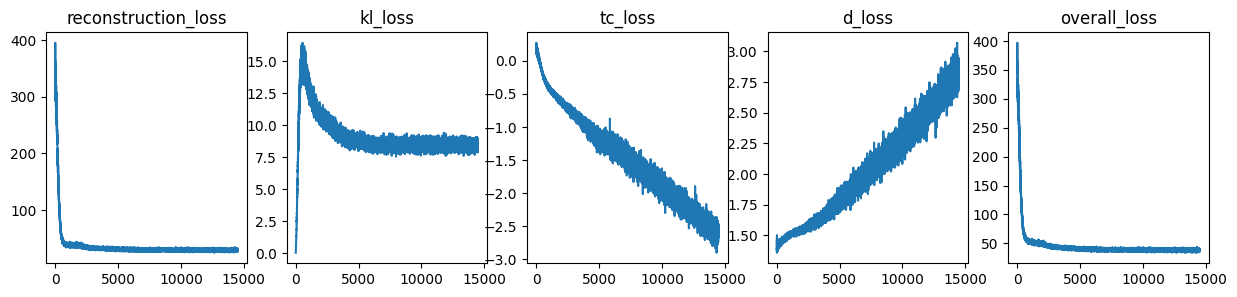

In [9]:
ds = torch.stack([target, background], axis=1)
dataloader = DataLoader(dataset=ds, batch_size=128, shuffle=True, drop_last=True)
optimizer = Adam(model.parameters(), lr=1e-4)
losses = train(model, dataloader, optimizer, epochs=100)